<a href="https://colab.research.google.com/github/OmkarKotwalProject/McDonalds_Work/blob/main/McDonalds_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and loading the dataset

In [1]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
import gensim
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
import sklearn.metrics as sm
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install pyspellchecker
!pip install Counter

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

     |████████████████████████████████| 2.7 MB 5.1 MB/s 
  Created wheel for Counter: filename=Counter-1.0.0-py3-none-any.whl size=5411 sha256=f3b9688ceb3379d4b8433d0cea722800a5193dfa8aa422ac30a864ee535b697a
  Stored in directory: /root/.cache/pip/wheels/f9/15/75/7a0462a00beb08e391f5da370ca409b56781d2501dba083fa3
Successfully built Counter
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
pd.set_option("display.max_rows",500)
pd.set_option("display.max_columns",None)
pd.set_option("display.max_colwidth",None)

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
cd /content/drive/MyDrive/CUSTOMER_REVIEWS/ScrapedReviews/PROJECT SCRAPED REVIEWS/McDonalds 3k/

/content/drive/MyDrive/CUSTOMER_REVIEWS/ScrapedReviews/PROJECT SCRAPED REVIEWS/McDonalds 3k


In [7]:
df = pd.read_excel('All_Reviews_MD.xlsx')

In [8]:
#Keeping the original as it is.
df_review=df 

THIS IS A BACKUP LOAD OF ORIGINAL DATAFRAME, ONLY USE IF something goes wrong and need to load the dataset again

In [9]:
# #FOR EMPTYING THE DATAFRAME
#df_review.drop(columns=['Review','Sentiment'],inplace=True)

In [10]:
# #FOR RELOADING WITH ORIGINAL RAW DATA
# df= pd.read_excel(io.BytesIO(uploaded['All_Reviews_PH.xlsx']))
# df_review=df

BACKUP CODE END

In [11]:
print(df_review.head())
print(df_review.shape)

                                                                                                     Review  \
0  Sitting arrangement is really bad, kept on moving here and there not happy, they should take care for it   
1                                                               Spacious.. Friendly, kind and helpful staff   
2                                  Always very crowded, non co-operative staff, will never advice to visit.   
3                                                                                            Amazing places   
4                                               Not service are good.always take time on single order also.   

   Sentiment  
0          0  
1          1  
2          0  
3          1  
4          0  
(3016, 2)


HOW MANY POSITIVE REVIEWS, HOW MANY NEGATIVE REVIEWS

In [12]:
print(df_review[df_review['Sentiment']==1].count())
print(df_review[df_review['Sentiment']==0].count())

Review       2212
Sentiment    2212
dtype: int64
Review       804
Sentiment    804
dtype: int64


In [13]:
print(df_review['Sentiment'].astype(int))

0       0
1       1
2       0
3       1
4       0
       ..
3011    1
3012    1
3013    1
3014    1
3015    1
Name: Sentiment, Length: 3016, dtype: int64


#PRE-PROCESSING!

1. Removing digits [\d]

In [14]:
#REMOVING NUMBERS 
df_review['Review']=df_review['Review'].replace('\d+','',regex=True)

2. Replacing special characters by empty space ‘ ‘ and dealing with any character that occurs more than twice: yummmmy => yummy


In [15]:
df_review['Review']=df_review['Review'].replace('\n', ' ',regex=True)
df_review['Review']=df_review['Review'].replace(('[^!|^.|^,|^;|^-|^@|^\w\s]'),"", regex = True)
for i in range(len(df_review)):
  sentence=df_review['Review'][i]
  sentence=sentence.replace('.', ' ')
  sentence=sentence.replace(',', ' ')
  sentence=sentence.replace('!', ' ')
  sentence=sentence.replace('.', ' ')
  sentence=sentence.replace(';', ' ')
  sentence=sentence.replace('-', ' ')
  sentence=sentence.replace('@', ' ')
  sentence=sentence.replace(')', ' ')
  sentence=sentence.replace('(', ' ')
  sentence=sentence.replace('{', ' ')
  sentence=sentence.replace('}', ' ')

  sentence=re.sub(r'(.)\1+', r'\1\1',sentence)   # yummmyyy => yummyy,  '     '=>'  '  #This line will remove char which occures more than 2 times consecutively.
  df_review['Review'][i]=sentence
print(df_review.head(10))

                                                                                                                              Review  \
0                           Sitting arrangement is really bad  kept on moving here and there not happy  they should take care for it   
1                                                                                         Spacious  Friendly  kind and helpful staff   
2                                                            Always very crowded  non cooperative staff  will never advice to visit    
3                                                                                                                     Amazing places   
4                                                                        Not service are good always take time on single order also    
5                                                                             Great place  quick service  food was tasty like alwats   
6                                               

3. REMOVING CHARACTERS WHICH ONLY OCCUR ONCE! ALSO REPLACING TWO CONSECUTIVE SPACES BY ONE

In [16]:
cnter=0
while(cnter<2):
  for i in range(len(df_review)):
    new_sentence=" "
    sentence=df_review['Review'][i]    #get the row i.e. sentence
    words=sentence.split()  #makes a list of the words in the sentence
    for word in words:      #check every words length and if it is less than 2, remove it
      if len(word)<2:
        words.remove(word)
    new_sentence=new_sentence.join(words) #Create a new sentence by joining all the words in the list with " " as a separator
    df_review['Review'][i]=new_sentence   #replace current row i.e. sentence by the new sentence
  cnter=cnter+1

In [17]:
print(df_review.head(5))

                                                                                                   Review  \
0  Sitting arrangement is really bad kept on moving here and there not happy they should take care for it   
1                                                                Spacious Friendly kind and helpful staff   
2                                    Always very crowded non cooperative staff will never advice to visit   
3                                                                                          Amazing places   
4                                              Not service are good always take time on single order also   

   Sentiment  
0          0  
1          1  
2          0  
3          1  
4          0  


4. Print the rows with Missing NAN values

In [18]:
print(df_review[df_review.isna().any(axis=1)])

Empty DataFrame
Columns: [Review, Sentiment]
Index: []


4. FINDING MISSPELLED WORDS AND CORRECTING THEM!

Algorithm used for correcting words:

    Create a list of misspelled words found in the dataset.
    Create a list of correctly spelled words found in the dataset.
    Use similar() function of 'SequenceMatcher' for finding similarity between words from both lists. If it is greater than 0.8, create a dictionary (dict['misspelled word'=correctly spelled word.
    Now traverse the dataset, while checking a row, extract its misspelled words, check if misspelled word is in the dictionary, if it is then replace it with correctly spelled word.



In [19]:
#This creates a list of sets of misspelled words found in each row.
from spellchecker import SpellChecker
spell=SpellChecker()
mis_list=[]
for i in range(len(df_review)):
  sentence=df_review['Review'][i].split()
  mis_sent=spell.unknown(sentence)
  mis_list.append(mis_sent)
  if set() in mis_list:
    mis_list.remove(set())
print("first 50 row's Misspelled words but they are in [{misspelled words list from row 1},{misspelled words list from row 2}]: ",mis_list[0:50])

first 50 row's Misspelled words but they are in [{misspelled words list from row 1},{misspelled words list from row 2}]:  [{'alwats'}, {'covid'}, {'bt', 'choclate'}, {'mcd', 'dnt'}, {'donalds', 'mc'}, {'tikki'}, {'estable'}, {'dilevery', 'contactless'}, {'coverd'}, {'mcpuff'}, {'tikki', 'mc'}, {'mcaloo', 'tikki', 'chesse'}, {'tikki', 'tomotoes'}, {'tikki', 'chatapata'}, {'mixfries', 'sider', 'mcdonaldspricepiri', 'mcdits', 'piri', 'theflavourjunction', '__for', 'frieslocation'}, {'sanitization'}, {'kfc'}, {'mcpuff', 'mutar', 'kabab'}, {'donalds', 'mc'}, {'hygienefoodrecommendation'}, {'foodwarden', 'donalds', 'tejasawant', 'mc'}, {'quntity', 'varietys'}, {'mc'}, {'mcfries', 'cripsy', 'mc'}, {'obvio'}, {'contactless'}, {'mcaloo', 'tikki', 'tikkis', 'tamatos'}, {'mc'}, {'tht'}, {'borivali', 'mcveggie', 'mcd', 'mc'}, {'mc'}, {'covid'}, {'differemt', 'ehuch', 'ambiemce', 'lovved', 'waitong'}, {'maharajamac'}, {'mc'}, {'mc'}, {'schezwan', 'mc'}, {'tikki', 'st', 'minimised'}, {'mcpuff', 'mc'

In [20]:
#Creating a list of misspelled words. (Basically extracting each set element from the mis_list and putting it into mis_mis_list)

from collections import Counter
mis_mis_list=[]
for i in mis_list:
  for j in i:
    mis_mis_list.append(j.lower())   #just making the words lower before appending to mis_mis_list

print("first 50 Misspelled words:",mis_mis_list[0:50]) #LIST OF MISSPELLED WORDS   
print("Total misspelled words: ",len(mis_mis_list)) #Note: this list is not a 'unique mispelled words' list, it has repeated occurences of them.


#Finding common words and their occurrences in the mis_mis_list #Just a trial code for common words finder.
cnt=Counter(mis_mis_list)
cmmn=cnt.most_common(100)   
print(cmmn)

first 50 Misspelled words: ['alwats', 'covid', 'bt', 'choclate', 'mcd', 'dnt', 'donalds', 'mc', 'tikki', 'estable', 'dilevery', 'contactless', 'coverd', 'mcpuff', 'tikki', 'mc', 'mcaloo', 'tikki', 'chesse', 'tikki', 'tomotoes', 'tikki', 'chatapata', 'mixfries', 'sider', 'mcdonaldspricepiri', 'mcdits', 'piri', 'theflavourjunction', '__for', 'frieslocation', 'sanitization', 'kfc', 'mcpuff', 'mutar', 'kabab', 'donalds', 'mc', 'hygienefoodrecommendation', 'foodwarden', 'donalds', 'tejasawant', 'mc', 'quntity', 'varietys', 'mc', 'mcfries', 'cripsy', 'mc', 'obvio']
Total misspelled words:  2116
[('mc', 257), ('mcd', 192), ('tikki', 110), ('borivali', 79), ('donalds', 72), ('mccafe', 56), ('zomato', 31), ('mcspicy', 28), ('rs', 27), ('mcaloo', 25), ('piri', 25), ('chinchwad', 23), ('macd', 22), ('mcveggie', 20), ('sv', 16), ('kandivali', 16), ('mcflurry', 16), ('kora', 15), ('mcds', 15), ('sakinaka', 13), ('mcpuff', 12), ('nd', 12), ('pm', 11), ('mcchicken', 11), ('pcmc', 10), ('chatpata', 9)

In [21]:
#REMOVING NAMES FROM THE LIST of misspelled words
names_list=['mc','donalds','mcdonalds','mcd','mccafe','tikki','zomato','mcspicy','chinchwad','mcveggie','sv','kandivali','mcflurry',
            'sakinaka','mcpuff','pm','pcmc','chatpata','dahisar','nonveg','shraddha','covid','contactless','pimpri','kfc','andheri'
            'mcdelivery','mcswirl','akhilesh','paytm','mcegg','mcmaharaja','jain','meetups','periperi','mcaloo']
for name in names_list:
  for j in range(len(mis_mis_list)):
    if name in mis_mis_list:
      mis_mis_list.remove(name)
print("Final Misspelled words list after removing names: (Showing only first 50) ",mis_mis_list[0:50]) #This is the list of misseplled words!



#Trial code for common words finder, again.
cnt=Counter(mis_mis_list)
cmmn=cnt.most_common(100)   #Finding common words and their occurrences in the mis_mis_list     
print(cmmn)    

Final Misspelled words list after removing names: (Showing only first 50)  ['alwats', 'bt', 'choclate', 'dnt', 'estable', 'dilevery', 'coverd', 'chesse', 'tomotoes', 'chatapata', 'mixfries', 'sider', 'mcdonaldspricepiri', 'mcdits', 'piri', 'theflavourjunction', '__for', 'frieslocation', 'sanitization', 'mutar', 'kabab', 'hygienefoodrecommendation', 'foodwarden', 'tejasawant', 'quntity', 'varietys', 'mcfries', 'cripsy', 'obvio', 'tikkis', 'tamatos', 'tht', 'borivali', 'differemt', 'ehuch', 'ambiemce', 'lovved', 'waitong', 'maharajamac', 'schezwan', 'st', 'minimised', 'deffers', 'rs', 'piri', 'favs', 'tikkas', 'ppt', 'rs', 'renovationcopying']
[('borivali', 79), ('rs', 27), ('piri', 25), ('macd', 22), ('kora', 15), ('mcds', 15), ('nd', 12), ('mcchicken', 11), ('kabab', 8), ('ds', 8), ('yumm', 8), ('bt', 7), ('ppl', 6), ('st', 5), ('maxican', 5), ('frnds', 5), ('café', 5), ('bday', 5), ('hrs', 5), ('aaloo', 5), ('pls', 5), ('choclate', 4), ('andheri', 4), ('mcdelivery', 4), ('nt', 4), ('r

In [22]:
#Finding a list of correctly spelled words!
#first, just creating a list of words found in the dataset
correct_word_list=[]
for i in range(len(df_review)):
  sentence=df_review['Review'][i]
  words=sentence.split()
  for word in words:
    correct_word_list.append(word.lower())
print(correct_word_list[0:50])


['sitting', 'arrangement', 'is', 'really', 'bad', 'kept', 'on', 'moving', 'here', 'and', 'there', 'not', 'happy', 'they', 'should', 'take', 'care', 'for', 'it', 'spacious', 'friendly', 'kind', 'and', 'helpful', 'staff', 'always', 'very', 'crowded', 'non', 'cooperative', 'staff', 'will', 'never', 'advice', 'to', 'visit', 'amazing', 'places', 'not', 'service', 'are', 'good', 'always', 'take', 'time', 'on', 'single', 'order', 'also', 'great']


In [23]:
#We have to make both lists mis_mis_list and correct_words_list contain unique words, not repeated words or 'remove' won't work!
print("total of all words of misspelled word list:",len(mis_mis_list))
print("total of all words of correct word list+misspelled word list:",len(correct_word_list))
mis_mis_list=list(set(mis_mis_list))
correct_word_list=list(set(correct_word_list))
print("total of unique words of misspelled word list:",len(mis_mis_list))
print("total of unique words of correct word list+missplled word list:",len(correct_word_list))
print("total of unique words of names list:",len(names_list))

total of all words of misspelled word list: 1127
total of all words of correct word list+misspelled word list: 70299
total of unique words of misspelled word list: 730
total of unique words of correct word list+missplled word list: 4784
total of unique words of names list: 35


In [24]:
print("correct word list length before removing misspelled words and names:",len(correct_word_list))
names_list=['mc','donalds','mcdonalds','mcd','mccafe','tikki','zomato','mcspicy','chinchwad','mcveggie','sv','kandivali','mcflurry',
            'sakinaka','mcpuff','pm','pcmc','chatpata','dahisar','nonveg','shraddha','covid','contactless','pimpri','kfc','andheri'
            'mcdelivery','mcswirl','akhilesh','paytm','mcegg','mcmaharaja','jain','meetups','periperi','mcaloo']
cnt=0
#Removing misspelled words from correct_word_list, found in mis_mis_list
for w in mis_mis_list:
  if w in correct_word_list:
    correct_word_list.remove(w)

#Removing names from correct_word_list, found in names_list
for n in names_list:
  if n in correct_word_list:
    correct_word_list.remove(n) 
print("correct word list length after removing misspelled words and names:",len(correct_word_list))

correct word list length before removing misspelled words and names: 4784
correct word list length after removing misspelled words and names: 4020


In [25]:
#Checking similarity between words from correct_word_list and mis_mis_list, if its more than 0.8, 
#do dictionary[misspelled word]=correct word
#TAKES 1 MINUTE+
from difflib import SequenceMatcher       #Library used for checking similarity

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()    #Function to check similarity!

dictionary={}
cnt=0
for cor_word in correct_word_list:
  for mis_word in mis_mis_list:
    ratio=similar(cor_word,mis_word)
    if(ratio>0.8):
      cnt=cnt+1
      dictionary[mis_word]=cor_word
      #print("Correct word:",cor_word,"    misspelled word:",mis_word,"      Ratio:",ratio)
print("This many words can be corrected: ",cnt)

This many words can be corrected:  472


In [26]:
#Replacing the misspelled words with correct words
#Takes almost 10 seconds
words_corrected_cnt=0
for i in range(len(df_review)):
  sentence=(df_review['Review'][i]).lower()
  
  misspelled_words=spell.unknown(sentence.split())
  #print("list:",misspelled_words)
  for misword in misspelled_words:
    if misword in dictionary:
      correct_word=dictionary[misword]
      print("before:",sentence)
      print("misspelled word: ",misword,"     ","correct word:",correct_word)
      print("After:",sentence)
      sentence=sentence.replace(misword,correct_word)
      words_corrected_cnt=words_corrected_cnt+1
  df_review['Review'][i]=sentence
  

before: great place quick service food was tasty like alwats
misspelled word:  alwats       correct word: always
After: great place quick service food was tasty like alwats
before: second time hot choclate leaked both burger totally wet cant eat last time same thing was done bt no response from your side
misspelled word:  choclate       correct word: chocolates
After: second time hot choclate leaked both burger totally wet cant eat last time same thing was done bt no response from your side
before: it was burnt tasted like hell for the first time being my fav meal from mcd but dnt know why it tasted like fried twice and smelled bad
misspelled word:  dnt       correct word: dont
After: it was burnt tasted like hell for the first time being my fav meal from mcd but dnt know why it tasted like fried twice and smelled bad
before: it took an hour for the order the food was cold and fries were not estable as they were very soggy by the time received the order extremely disappointed want my m

In [27]:
#This many words were corrected and replaced
print(words_corrected_cnt)

414


5. Removing stopwords

In [28]:
print(df_review['Review'].head())

0    sitting arrangement is really bad kept on moving here and there not happy they should take care for it
1                                                                  spacious friendly kind and helpful staff
2                                      always very crowded non cooperative staff will never advice to visit
3                                                                                            amazing places
4                                                not service are good always take time on single order also
Name: Review, dtype: object


In [29]:
from nltk.corpus import stopwords
sw=stopwords.words("english")
print(sw)
#Removing the words below from the stopword list as they do impact the outcome when doing sentiment analysis. 
sw.append('would')
words=['no','not']
sw.remove('not')
sw.remove('no')
sw.remove('don\'t')
sw.remove('didn\'t')
sw.remove('wouldn\'t')
sw.remove('wouldn')
sw.remove('won\'t')
sw.remove('didn')
sw.remove('don')
sw.remove('isn\'t')
sw.remove('isn')
sw.remove('couldn\'t')
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Making 'Review' lower so I can remove stopwords

In [30]:
df_review['Review']=df_review['Review'].str.lower()

In [31]:
df_review['Review']=df_review['Review'].apply(lambda x:" ".join(x for x in str(x).split() if x not in sw))
print(df_review.head())

                                                           Review  Sentiment
0  sitting arrangement really bad kept moving not happy take care          0
1                            spacious friendly kind helpful staff          1
2         always crowded non cooperative staff never advice visit          0
3                                                  amazing places          1
4             not service good always take time single order also          0


In [32]:
#TOTAL WORDS AFTER REMOVING STOP WORDS!
p_list=[]
for i in range(len(df_review)):
  ent=df_review['Review'][i].split()
  p_list.append(ent)

word_list=[]
for element in p_list:
  for word in element:
    word_list.append(word)
print(len(word_list))

42366


Exploratory Data Analysis

a. For positive reviews

In [33]:
pos_reviews_list=[]
for rev in df_review[df_review['Sentiment']==1].Review:
  sent_list=rev.split()
  for w in sent_list:
    pos_reviews_list.append(w)


#Trial code for common words finder, again.
cnt=Counter(pos_reviews_list)
cmmn=cnt.most_common(100)   #Finding common words and their occurrences in the mis_mis_list     
print(cmmn)

[('good', 1102), ('place', 1036), ('food', 647), ('service', 490), ('nice', 403), ('mcdonalds', 384), ('burger', 311), ('mc', 302), ('best', 291), ('fries', 275), ('also', 272), ('always', 262), ('staff', 256), ('time', 252), ('one', 250), ('great', 247), ('friends', 205), ('chicken', 204), ('outlet', 203), ('taste', 192), ('like', 190), ('love', 183), ('burgers', 178), ('ambience', 173), ('mcd', 165), ('visit', 159), ('quality', 156), ('quick', 152), ('awesome', 148), ('friendly', 145), ('well', 145), ('really', 141), ('coffee', 137), ('not', 126), ('fast', 123), ('meal', 117), ('hangout', 116), ('crowded', 114), ('favourite', 110), ('peri', 110), ('try', 109), ('go', 107), ('amazing', 106), ('order', 106), ('mac', 104), ('tasty', 103), ('family', 101), ('tikki', 93), ('experience', 92), ('new', 92), ('spicy', 84), ('donalds', 83), ('location', 83), ('get', 82), ('maharaja', 81), ('veg', 79), ('menu', 79), ('loved', 78), ('ordered', 77), ('must', 76), ('delivery', 76), ('aloo', 75), (

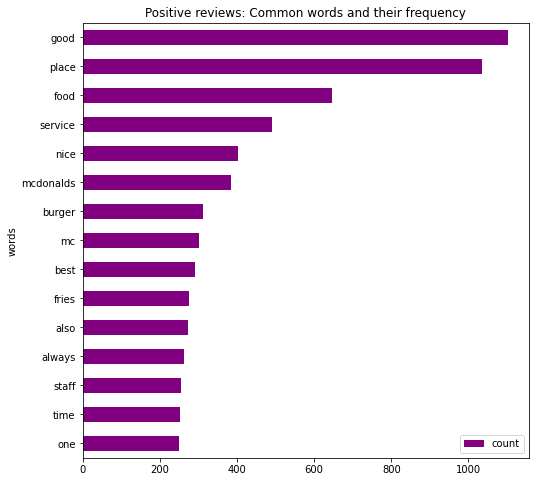

In [34]:
#cnt=Counter(df_review[df_review['Sentiment']==1].Review)
cnt=Counter(pos_reviews_list)
pos_common_words=pd.DataFrame(cnt.most_common(15), columns=['words','count'])
pos_common_words.head()

fig,ax=plt.subplots(figsize=(8,8))
pos_common_words.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color='purple')
ax.set_title("Positive reviews: Common words and their frequency")
plt.show()

In [35]:
#Creating bi-grams
bigram_measures=nltk.collocations.BigramAssocMeasures()

finder=nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in df_review[df_review['Sentiment']==1].Review])

In [36]:
finder.apply_freq_filter(30)
bigram_scores=finder.score_ngrams(bigram_measures.pmi)
#print('_'.join(bigram_scores[0][0]))
print(len(bigram_scores))

32


In [37]:
bigram_scores[0][0]
cnt_list=[]
for gram in bigram_scores:
  x = '_'.join(gram[0])
  cnt_list.append((x,gram[1]))
print(cnt_list[0:10])

[('aloo_tikki', 7.9597635087309015), ('pocket_friendly', 7.495263869515728), ('quick_bite', 7.334136041695595), ('must_try', 7.076913636196048), ('peri_peri', 7.063738247448313), ('french_fries', 6.651612343589372), ('mc_donalds', 6.297742980758745), ('friends_family', 5.636689395660701), ('hangout_friends', 5.629564961227318), ('mc_cafe', 5.498168764869726)]


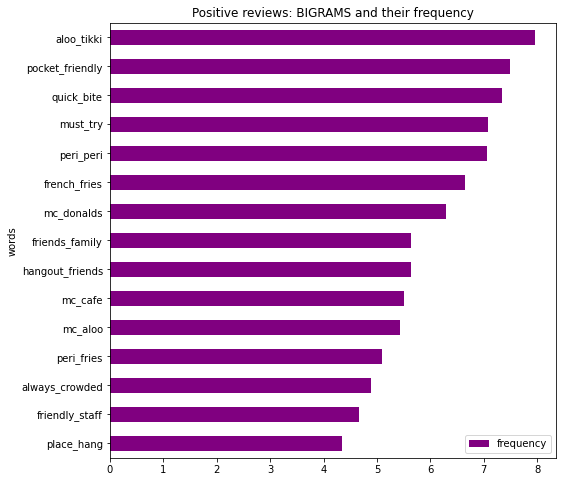

In [38]:
#cnt=Counter(df_review[df_review['Sentiment']==0].Review)
cnt=Counter(cnt_list)
pos_common_words=pd.DataFrame(cnt_list[0:15], columns=['words','frequency'])
pos_common_words.head()

fig,ax=plt.subplots(figsize=(8,8))
pos_common_words.sort_values(by='frequency').plot.barh(x='words',y='frequency',ax=ax,color='purple')
ax.set_title("Positive reviews: BIGRAMS and their frequency")
plt.show()

b. For Negative Reviews

In [39]:
neg_reviews_list=[]
for rev in df_review[df_review['Sentiment']==0].Review:
  sent_list=rev.split()
  for w in sent_list:
    neg_reviews_list.append(w)


#Trial code for common words finder, again.
cnt=Counter(neg_reviews_list)
cmmn=cnt.most_common(100)   #Finding common words and their occurrences in the mis_mis_list     
print(cmmn)

[('not', 404), ('order', 205), ('burger', 181), ('food', 174), ('service', 157), ('no', 142), ('fries', 139), ('good', 135), ('place', 129), ('time', 122), ('mcdonalds', 109), ('delivery', 104), ('like', 91), ('ordered', 86), ('also', 80), ('one', 77), ('mc', 75), ('always', 73), ('crowded', 73), ('staff', 72), ('even', 72), ('quality', 72), ('outlet', 72), ('dont', 71), ('mcd', 70), ('bad', 65), ('taste', 63), ('worst', 63), ('meal', 62), ('coke', 62), ('cold', 60), ('chicken', 58), ('get', 56), ('didnt', 53), ('never', 52), ('burgers', 52), ('experience', 49), ('received', 48), ('really', 47), ('much', 41), ('poor', 40), ('disappointed', 39), ('give', 39), ('less', 38), ('tikki', 38), ('fresh', 37), ('customers', 36), ('take', 35), ('hot', 35), ('please', 33), ('pathetic', 32), ('eat', 32), ('money', 32), ('well', 31), ('know', 30), ('sauce', 30), ('cheese', 30), ('times', 30), ('quantity', 30), ('delivered', 30), ('go', 30), ('veg', 30), ('customer', 29), ('half', 29), ('got', 29), 

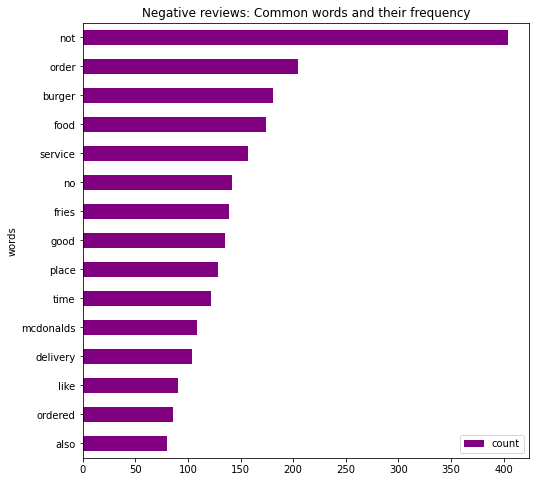

In [40]:
#cnt=Counter(df_review[df_review['Sentiment']==0].Review)
cnt=Counter(neg_reviews_list)
pos_common_words=pd.DataFrame(cnt.most_common(15), columns=['words','count'])
pos_common_words.head()

fig,ax=plt.subplots(figsize=(8,8))
pos_common_words.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color='purple')
ax.set_title("Negative reviews: Common words and their frequency")
plt.show()

In [41]:
#Creating bi-grams
bigram_measures=nltk.collocations.BigramAssocMeasures()

finder=nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in df_review[df_review['Sentiment']==0].Review])

In [42]:
finder.apply_freq_filter(10)
bigram_scores=finder.score_ngrams(bigram_measures.pmi)
#print('_'.join(bigram_scores[0][0]))
print(len(bigram_scores))

22


In [43]:
bigram_scores[0][0]
cnt_list=[]
for gram in bigram_scores:
  x = '_'.join(gram[0])
  cnt_list.append((x,gram[1]))
print(cnt_list[0:10])

[('waste_money', 8.395846489214085), ('aloo_tikki', 7.887391425547277), ('mc_donalds', 7.260137203109682), ('mc_veggie', 7.2374171266096), ('cold_drink', 7.060112594801691), ('french_fries', 6.539939822324369), ('happy_meal', 6.44165017882721), ('dont_know', 6.302682898075769), ('always_crowded', 5.864194278008998), ('bad_experience', 5.481234856541512)]


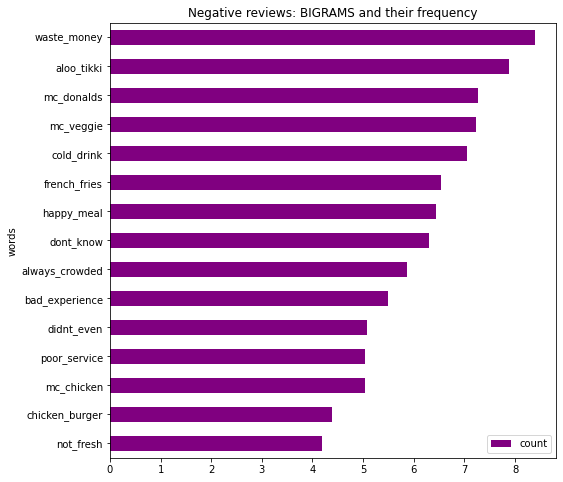

In [44]:
#cnt=Counter(df_review[df_review['Sentiment']==0].Review)
cnt=Counter(cnt_list)
pos_common_words=pd.DataFrame(cnt_list[0:15], columns=['words','count'])
pos_common_words.head()

fig,ax=plt.subplots(figsize=(8,8))
pos_common_words.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color='purple')
ax.set_title("Negative reviews: BIGRAMS and their frequency")
plt.show()

6. TOKENIZATION

In [45]:
#Tokenization done to apply Lemmatization
w_tokenizer=nltk.tokenize.WhitespaceTokenizer()
lemmatizer=nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
  return [lemmatizer.lemmatize(w,'v') for w in w_tokenizer.tokenize(text)]

df_review['Review']=df_review.Review.apply(lemmatize_text)
print(df_review.head())

                                                                Review  \
0  [sit, arrangement, really, bad, keep, move, not, happy, take, care]   
1                           [spacious, friendly, kind, helpful, staff]   
2       [always, crowd, non, cooperative, staff, never, advice, visit]   
3                                                       [amaze, place]   
4        [not, service, good, always, take, time, single, order, also]   

   Sentiment  
0          0  
1          1  
2          0  
3          1  
4          0  


From tokenized to normal

In [46]:
df_review['NewReview'] = df_review['Review'].apply(lambda s1: ' '.join(map(str,s1)) )

print(df_review['NewReview'].head())

0    sit arrangement really bad keep move not happy take care
1                        spacious friendly kind helpful staff
2       always crowd non cooperative staff never advice visit
3                                                 amaze place
4         not service good always take time single order also
Name: NewReview, dtype: object


In [47]:
df_review['NewReview']=df_review['NewReview'].str.lower()
df_review.head()

,Review,Sentiment,NewReview
0,"[sit, arrangement, really, bad, keep, move, not, happy, take, care]",0,sit arrangement really bad keep move not happy take care
1,"[spacious, friendly, kind, helpful, staff]",1,spacious friendly kind helpful staff
2,"[always, crowd, non, cooperative, staff, never, advice, visit]",0,always crowd non cooperative staff never advice visit
3,"[amaze, place]",1,amaze place
4,"[not, service, good, always, take, time, single, order, also]",0,not service good always take time single order also


# Sentiment Analysis

In [48]:
print("The number of samples in the dataset!")
pos_percent=(len(df_review[df_review['Sentiment']==1])/len(df_review)*100)
print("Positive reviews percentage: ",round(pos_percent,2),"%")
neg_percent=(len(df_review[df_review['Sentiment']==0])/len(df_review)*100)
print("Negative reviews percentage: ",round(neg_percent,2),"%")
print("Negative reviews: ",len(df_review[df_review['Sentiment']==0]))
print("Positive reviews: ",len(df_review[df_review['Sentiment']==1]))

The number of samples in the dataset!
Positive reviews percentage:  73.34 %
Negative reviews percentage:  26.66 %
Negative reviews:  804
Positive reviews:  2212


Train-test split starts here!

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
train_data,test_data=train_test_split(df_review,test_size=0.2,random_state=50)  #keep random_state=50 for higher precision and recall of 0 class when using SVM
#train_data,test_data=train_test_split(new_df_review,test_size=0.4,random_state=25)

In [51]:
print(df_review.shape)
print('test_data(Positive):',test_data[test_data['Sentiment']==1].count())
print('test_data(Negative):',test_data[test_data['Sentiment']==0].count())

print("train_data (Positive):",train_data[train_data['Sentiment']==1].count())
print('train_data (Negative):',train_data[train_data['Sentiment']==0].count())

(3016, 3)
test_data(Positive): Review       439
Sentiment    439
NewReview    439
dtype: int64
test_data(Negative): Review       165
Sentiment    165
NewReview    165
dtype: int64
train_data (Positive): Review       1773
Sentiment    1773
NewReview    1773
dtype: int64
train_data (Negative): Review       639
Sentiment    639
NewReview    639
dtype: int64


In [52]:
X_train=train_data['NewReview']
y_train=train_data['Sentiment']
X_test=test_data['NewReview']
y_test=test_data['Sentiment']

In [53]:
print(X_test.head(50))

1890                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         visit come know love
1713                                                                                                                                                                                                                                                                                                                                                                                  

In [54]:
print(y_train.shape)

(2412,)


In [55]:
print(X_train.head())
print(X_test.head())

156                                       doesnt know taste mcdonalds burger know even breakfast range yup today morning visit borivali outlet breakfast friends good
1727                                                                                 burger quality quite sad give stomach issue rd time end upset stomach eat burger
2892    taste always best afterall mcd staff really weird turn air condition system customers spend extra time staff egoistic behaviour much rude rest fine like macs
2117                                                                                                                                                            crowd
2661                                                                                                                                                             well
Name: NewReview, dtype: object
1890                                                                                                                    visit come know lov

7. Vectorizer

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [57]:
train_vectorizer=TfidfVectorizer(use_idf=True,lowercase=True,strip_accents='ascii')
train_review_tfidf=train_vectorizer.fit_transform(X_train)

In [58]:
# #CountVectorizer
# from sklearn.feature_extraction.text import CountVectorizer
# train_vectorizer=CountVectorizer()
# train_review_tfidf=train_vectorizer.fit_transform(X_train)

In [59]:
#Gensim's word2vec
# !pip install gensim

In [60]:
print(train_review_tfidf.shape)
type(train_review_tfidf)

(2412, 3188)


scipy.sparse.csr.csr_matrix

a. LOGISTIC REGRESSION

In [61]:
log_model=LogisticRegression().fit(train_review_tfidf, y_train)

In [62]:
cross_val_score(log_model,train_review_tfidf,y_train,scoring='accuracy',cv=5).mean()

0.898428734654605

In [63]:
#USE THIS WHEN TESTING ON SPLIT TEST DATA
nr=train_vectorizer.transform(X_test)
log_model.predict(nr)

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [64]:
predicted=log_model.predict(nr)
p=pd.DataFrame(predicted)
actual=y_test

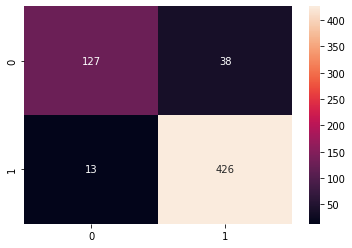

In [65]:
import seaborn as sns
cf_matrix=sm.confusion_matrix(actual,p)
sns.heatmap(cf_matrix,annot=True,fmt='g')

In [66]:
#Classification Report
from sklearn.metrics import classification_report
print(classification_report(actual,predicted))

              precision    recall  f1-score   support

           0       0.91      0.77      0.83       165
           1       0.92      0.97      0.94       439

    accuracy                           0.92       604
   macro avg       0.91      0.87      0.89       604
weighted avg       0.92      0.92      0.91       604



RANDOM FOREST

In [67]:
from sklearn.ensemble import RandomForestClassifier
rfclassifier=RandomForestClassifier(n_estimators=400,criterion='entropy',random_state=0)
rfclassifier.fit(train_review_tfidf,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=400, random_state=0)

In [68]:
nr=train_vectorizer.transform(X_test)


In [69]:
predicted=rfclassifier.predict(nr)
p=pd.DataFrame(predicted)
actual=y_test

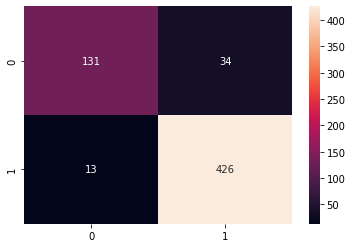

In [70]:
cf_matrix=sm.confusion_matrix(actual,p)
sns.heatmap(cf_matrix,annot=True,fmt='g')

In [71]:
#Classification Report
from sklearn.metrics import classification_report
print(classification_report(actual,predicted))

              precision    recall  f1-score   support

           0       0.91      0.79      0.85       165
           1       0.93      0.97      0.95       439

    accuracy                           0.92       604
   macro avg       0.92      0.88      0.90       604
weighted avg       0.92      0.92      0.92       604



b. SVM

In [72]:
from sklearn.svm import SVC
svclassifier=SVC(kernel='rbf',C=10,gamma=1)
svclassifier.fit(train_review_tfidf,y_train)

SVC(C=10, gamma=1)

In [73]:
nr=train_vectorizer.transform(X_test)
svclassifier.predict(nr)

array([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,

In [74]:
predicted=svclassifier.predict(nr)
p=pd.DataFrame(predicted)
actual=y_test

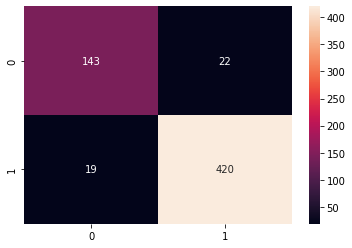

In [75]:
cf_matrix=sm.confusion_matrix(actual,p)
sns.heatmap(cf_matrix,annot=True,fmt='g')

In [76]:
#Classification Report
from sklearn.metrics import classification_report
print(classification_report(actual,predicted))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87       165
           1       0.95      0.96      0.95       439

    accuracy                           0.93       604
   macro avg       0.92      0.91      0.91       604
weighted avg       0.93      0.93      0.93       604



Hyperparameter tuning the SVM!

In [77]:
# from sklearn.model_selection import GridSearchCV

In [78]:
# param_grid={'C':[0.1,1,10,100],
#             'gamma':[1,0.1,0.01,0.001,0.0001],
#             'kernel':['rbf']}

# grid=GridSearchCV(SVC(),param_grid,verbose=5)
# grid.fit(train_review_tfidf,y_train)

In [79]:
# print(grid.best_params_)
# print(grid.best_score_)
# print(grid.best_estimator_)

# Topic Modelling

In [80]:
import warnings
warnings.filterwarnings("ignore")

In [81]:
import nltk
nltk.download('averaged_perceptron_tagger')
import spacy
nlp = spacy.load("en_core_web_sm")
!pip install pyLDAvis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
     |████████████████████████████████| 1.7 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=52338eed096431b5bd7845c0e5fcf28ef40b509e89cdaae2552904c157ff4648
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [82]:
corpus_bert=pd.DataFrame(df_review[df_review['Sentiment']==0].NewReview)
corpus_lda=pd.DataFrame(df_review[df_review['Sentiment']==0].NewReview)

corpus_bert=corpus_bert.reset_index()
corpus_lda=corpus_lda.reset_index()

In [83]:
print(corpus_bert.head())

   index                                                 NewReview
0      0  sit arrangement really bad keep move not happy take care
1      2     always crowd non cooperative staff never advice visit
2      4       not service good always take time single order also
3      6              pathetic service no covid regulations follow
4      7                 order late also food cold thats not taste


In [84]:
train_vectorizer=TfidfVectorizer(use_idf=True,lowercase=True,strip_accents='ascii')
tfidf_=train_vectorizer.fit_transform(corpus_lda.NewReview)

num_components=8
lda=LatentDirichletAllocation(n_components=num_components,max_iter=100)
lda_tfidf=lda.fit(tfidf_)

In [85]:
#pyLDAvis for tfidf 
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_tfidf,tfidf_,train_vectorizer)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.255959 -0.000045       1        1  55.810894
0     -0.037169 -0.087326       2        1   9.154347
1     -0.033808  0.028374       3        1   6.878562
6     -0.043526  0.015260       4        1   6.203910
5     -0.043968  0.014576       5        1   5.671805
4     -0.024227  0.007657       6        1   5.625577
2     -0.039198  0.010131       7        1   5.564861
3     -0.034063  0.011373       8        1   5.090044, topic_info=                Term       Freq      Total Category  logprob  loglift
414            crowd  16.000000  16.000000  Default  30.0000  30.0000
1617         service  17.000000  17.000000  Default  29.0000  29.0000
994             late   5.000000   5.000000  Default  28.0000  28.0000
457         delivery  13.000000  13.000000  Default  27.0000  27.0000
1220              no  13.000000  13.000000  Default  26.0000  26.0000
1663            slow   4.000000   4.000000  Default  25.0000  25.0000
1558            rush   3.000000   3.000000  Default  24.0000  24.0000
133              bad  11.000000  11.000000  Default  23.0000  23.0000
1317            park   3.000000   3.000000  Default  22.0000  22.0000
1233             not  32.000000  32.000000  Default  21.0000  21.0000
1439         provide   3.000000   3.000000  Default  20.0000  20.0000
692             food  17.000000  17.000000  Default  19.0000  19.0000
1577           sauce   5.000000   5.000000  Default  18.0000  18.0000
1279           order  25.000000  25.000000  Default  17.0000  17.0000
1451         quality  11.000000  11.000000  Default  16.0000  16.0000
391           costly   2.000000   2.000000  Default  15.0000  15.0000
1722           staff   7.000000   7.000000  Default  14.0000  14.0000
624        expensive   1.000000   1.000000  Default  13.0000  13.0000
761             good  17.000000  17.000000  Default  12.0000  12.0000
1202            need   4.000000   4.000000  Default  11.0000  11.0000
2005           waste   2.000000   2.000000  Default  10.0000  10.0000
358        condition   1.000000   1.000000  Default   9.0000   9.0000
277           cheese   4.000000   4.000000  Default   8.0000   8.0000
1378          please   4.000000   4.000000  Default   7.0000   7.0000
120        available   4.000000   4.000000  Default   6.0000   6.0000
379             cook   2.000000   2.000000  Default   5.0000   5.0000
729              fry  17.000000  17.000000  Default   4.0000   4.0000
1013         lettuce   1.000000   1.000000  Default   3.0000   3.0000
216           burger  17.000000  17.000000  Default   2.0000   2.0000
846         horrible   2.000000   2.000000  Default   1.0000   1.0000
1860            time  13.433997  13.810180   Topic1  -4.6829   0.5556
216           burger  17.240812  17.725661   Topic1  -4.4334   0.5555
729              fry  17.422346  17.924206   Topic1  -4.4230   0.5548
1233             not  31.695643  32.769007   Topic1  -3.8245   0.5499
1484         receive  10.235525  10.611526   Topic1  -4.9549   0.5471
329             cold   9.702704  10.078680   Topic1  -5.0083   0.5452
751             give   9.175737   9.551781   Topic1  -5.0642   0.5430
326             coke   8.447820   8.823829   Topic1  -5.1468   0.5397
477            didnt   8.331162   8.707180   Topic1  -5.1607   0.5391
1801            take   7.922146   8.298182   Topic1  -5.2111   0.5368
1279           order  24.472455  25.637377   Topic1  -4.0832   0.5367
595             even   7.884237   8.260289   Topic1  -5.2159   0.5366
761             good  16.653036  17.456021   Topic1  -4.4681   0.5361
1102       mcdonalds   9.797923  10.279215   Topic1  -4.9985   0.5352
1369           place  14.593902  15.335424   Topic1  -4.6001   0.5336
718            fresh   7.359119   7.735096   Topic1  -5.2848   0.5334
520             dont   7.302596   7.678653   Topic1  -5.2925   0.5330
455          deliver   7.202459   7.578419   Topic1  -5.3

USING BERT FOR TOPIC MODELLING!

In [86]:
import warnings
warnings.filterwarnings("ignore")

In [87]:
!pip install bertopic[visualization] --quiet

     |████████████████████████████████| 58 kB 2.8 MB/s 
     |████████████████████████████████| 79 kB 6.7 MB/s 
     |████████████████████████████████| 5.2 MB 51.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 88 kB 4.0 MB/s 
     |████████████████████████████████| 4.2 MB 24.8 MB/s 
     |████████████████████████████████| 1.2 MB 51.1 MB/s 
     |████████████████████████████████| 84 kB 2.7 MB/s 
     |████████████████████████████████| 636 kB 47.6 MB/s 
     |████████████████████████████████| 6.6 MB 38.5 MB/s 
     |████████████████████████████████| 1.1 MB 34.0 MB/s 


In [88]:
from bertopic import BERTopic

In [89]:
corpus=list(corpus_bert.NewReview)
print(corpus[0:5])

['sit arrangement really bad keep move not happy take care', 'always crowd non cooperative staff never advice visit', 'not service good always take time single order also', 'pathetic service no covid regulations follow', 'order late also food cold thats not taste']


In [90]:
bert_model=BERTopic(language="english", nr_topics=15)

In [91]:
topics,probs=bert_model.fit_transform(corpus)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [92]:
#Getting most frequent topics
bert_model.get_topic_freq()

,Topic,Count
0,-1,214
1,0,126
2,1,123
3,2,58
4,3,51
5,4,32
6,5,29
7,6,26
8,7,25
9,8,22


In [93]:
#bert_model.get_topic(0)
bert_model.get_topics()

{-1: [('order', 0.035989062797371185),
  ('not', 0.03553771925082929),
  ('food', 0.02588279944104949),
  ('fry', 0.024507851960777385),
  ('place', 0.023935552056966024),
  ('bad', 0.023490871455493247),
  ('get', 0.02193101861942972),
  ('burger', 0.021264383587077537),
  ('one', 0.02123288889699344),
  ('no', 0.02049380269105847)],
 0: [('place', 0.033417752980241626),
  ('service', 0.025957472981593635),
  ('time', 0.025941691589334452),
  ('staff', 0.024630966046841722),
  ('mcdonalds', 0.02460043162812307),
  ('crowd', 0.023826518230554598),
  ('outlet', 0.022489142912333743),
  ('not', 0.021619749851864406),
  ('order', 0.021065693931712984),
  ('no', 0.020734199203563557)],
 1: [('burger', 0.07968332438606984),
  ('chicken', 0.05728787069458762),
  ('mc', 0.04976462335151664),
  ('sauce', 0.04037922061633835),
  ('not', 0.035474867040746226),
  ('order', 0.033964122884830195),
  ('taste', 0.031426261403571194),
  ('tikki', 0.03131113218849483),
  ('quality', 0.02904888150075304

In [94]:
# bert_model.visualize_topics()

In [95]:
topic_list=[i for i in range(len(bert_model.get_topics())-1)]
print(topic_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [96]:
bert_model.visualize_barchart(topic_list, n_words=10, height=300)

If you want to see the complaints (reviews) wrt to the topic

In [97]:
df_tpc = pd.DataFrame({'topic': topics, 'document': corpus})

In [99]:
df_tpc[df_tpc['topic']==11].document

0                                                            sit arrangement really bad keep move not happy take care
91                                                                                 seat not adequatestaff not helpful
96                                                                                      always crowd not enough space
128                                                                             crowd place difficult find table seat
168                                                                                 always crowd not enough place sit
194                                                always crowd seat suffocate not amongst favorite place eat hangout
378                                                                                    per public rush sit area small
441    place always crowd seat limit capacity mostly full service fast half seat space nonairconditioned not good mcd
506                                                     